<a href="https://colab.research.google.com/github/aadityashar/gold_price_prediction_using_arima/blob/master/Gold_price_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
from statsmodels.tsa.stattools import adfuller
import io
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import Holt,ExponentialSmoothing

In [4]:
from google.colab import files

file = files.upload()

Saving GCF_2008.csv to GCF_2008 (1).csv


In [6]:
df_gold=pd.read_csv('GCF_2008.csv') #incase this doesnt work upload the database you have. and change file addr

In [7]:
df_gold.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2008-08-11,826.400024,831.900024,780.900024,786.000000,786.000000,455
1,2008-08-18,792.000000,836.599976,789.599976,827.400024,827.400024,277
2,2008-08-25,819.799988,842.599976,819.799988,829.299988,829.299988,1228
3,2008-09-01,829.900024,840.700012,790.799988,797.599976,797.599976,374
4,2008-09-08,811.000000,813.200012,739.000000,760.299988,760.299988,210


In [9]:
df_gold[df_gold.isnull()]#No NaN values in dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
622,NaN,NaN,NaN,NaN,NaN,NaN,NaN
623,NaN,NaN,NaN,NaN,NaN,NaN,NaN
624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_gold.Date=pd.to_datetime(df_gold.Date)

In [13]:
df_gold.dtypes# We have to convert date to Datetime object

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [14]:
df_gold.index=df_gold.Date #indexing dataframe by date

In [15]:
df_gold.drop('Date',inplace=True,axis=1)

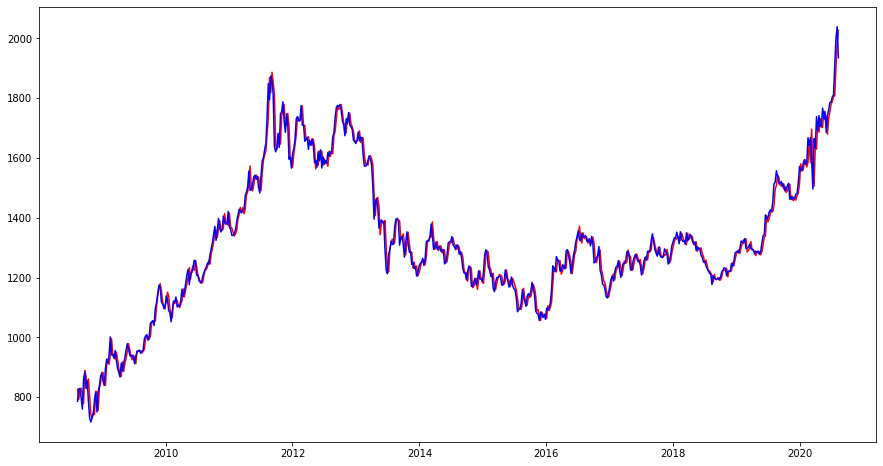

In [17]:
fig=plt.figure(figsize=(15,8))
plt.plot(df_gold.Open,color='red')
plt.plot(df_gold.Close,color='blue')

In [74]:
train_df=df_gold.Open[:'2020-03-30']
test_df=df_gold.Open['2020-03-30':]

In [34]:
def check_stationary(df_):
 rollingmean=df_.rolling(52).mean() #taking mean of 52 weeks gold price(one year)
 rollingstd=df_.rolling(52).std()
 plt.figure(figsize=(12,6))
 plt.plot(df_,color='blue',label='gold_price')
 plt.plot(rollingmean,color='black',label='mean')
 plt.plot(rollingstd,color='green',label='standard deviation') #Laude ka stationary hai ye toh
 plt.legend(loc='best')
 dftest=adfuller(df_,autolag='AIC')
 df_test=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
 df_test
 for key,value in dftest[4].items():
        df_test['Critical Value (%s)'%key] = value
 print(df_test)

Test Statistic                  -2.057177
p-value                          0.262079
#Lags Used                       0.000000
Number of Observations Used    607.000000
Critical Value (1%)             -3.441169
Critical Value (5%)             -2.866313
Critical Value (10%)            -2.569312
dtype: float64


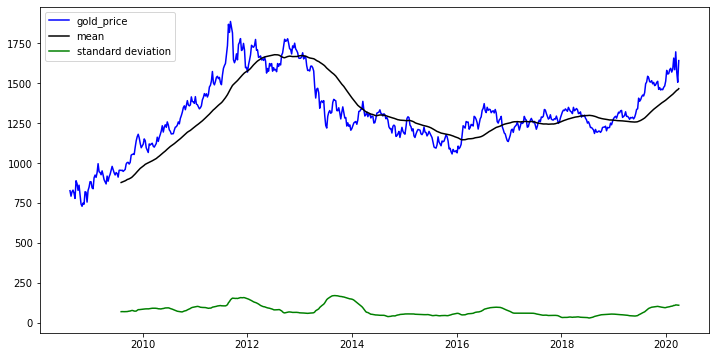

In [39]:
check_stationary(train_df)

Test Statistic                -1.516337e+01
p-value                        6.543031e-28
#Lags Used                     2.000000e+00
Number of Observations Used    6.040000e+02
Critical Value (1%)           -3.441223e+00
Critical Value (5%)           -2.866337e+00
Critical Value (10%)          -2.569325e+00
dtype: float64


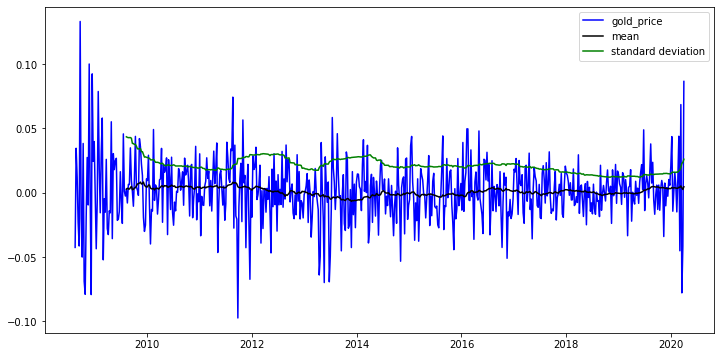

In [41]:
price_log=np.log(train_df)
moving_diff_shift=price_log-price_log.shift()
moving_diff_shift =moving_diff_shift.dropna()    #STABILIZING THE MEAN
check_stationary(moving_diff_shift)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


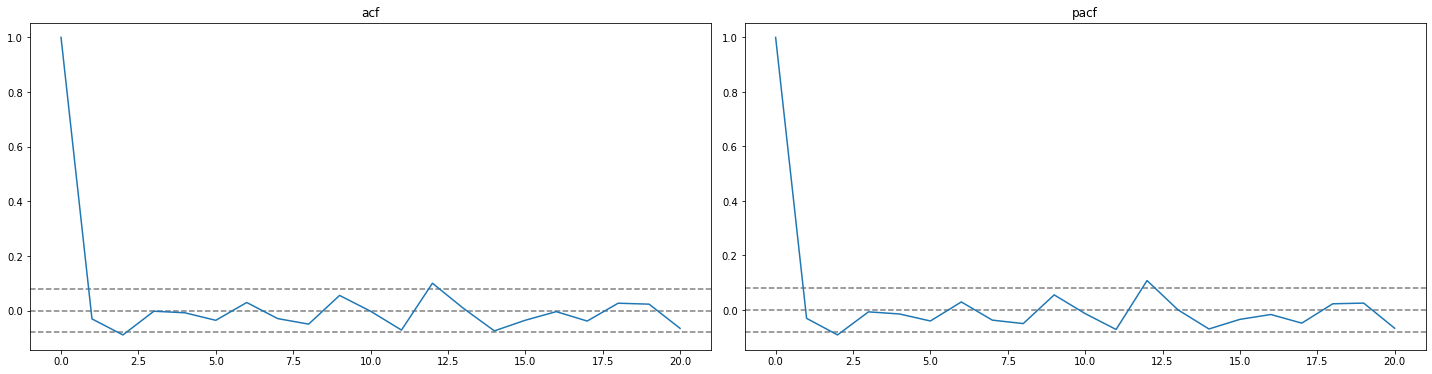

In [48]:
lag_acf=acf(moving_diff_shift,nlags=20)                 #Used this instead of exp
lag_pacf=pacf(moving_diff_shift,nlags=20,method='ols')
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.title('acf')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.plot(lag_acf)

plt.subplot(2,2,2)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(moving_diff_shift)),linestyle='--',color='gray')
plt.title('pacf')
plt.plot(lag_pacf)
plt.tight_layout() #AR(2)  to be used(refer link below) ARIMA(1,1,1)

In [50]:
nolog= ARIMA(train_df,order=(1,1,0))   #I got this by taking the arima function of the open price values directly
ogscale=nolog.fit()
og1=pd.Series(ogscale.fittedvalues,copy=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)


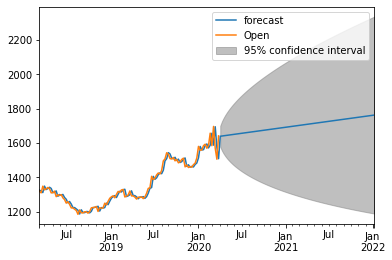

In [52]:
og=ogscale.plot_predict(500,700)

In [69]:
forecasts=ogscale.forecast(steps=20)
forecasts=pd.DataFrame(forecasts,index=['Forecast','Standard Error','Confidence Interval'])
forecasts=forecasts.transpose()
ind=pd.date_range(start='2020-03-30',freq='W',periods=20)
forecasts.index=ind
forecasts

,Forecast,Standard Error,Confidence Interval
2020-04-05,1638.97,31.0981,"[1578.0193355917315, 1699.92153206135]"
2020-04-12,1640.4,43.4002,"[1555.3403152088515, 1725.4660242822572]"
2020-04-19,1641.74,52.9282,"[1538.0015028726089, 1745.4761123498092]"
2020-04-26,1643.08,60.985,"[1523.548643875723, 1762.6053958384687]"
2020-05-03,1644.42,68.0951,"[1510.9511592934534, 1777.8791684023893]"
2020-05-10,1645.75,74.53,"[1499.6771368348473, 1791.829482461967]"
2020-05-17,1647.09,80.4519,"[1489.4086851991144, 1804.7742256027116]"
2020-05-24,1648.43,85.9667,"[1479.9378690931362, 1816.9213332162458]"
2020-05-31,1649.77,91.1486,"[1471.1198487184647, 1828.4156450984055]"
2020-06-07,1651.11,96.0512,"[1462.848942505525, 1839.3628428188354]"


In [91]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test_df[:3],forecasts.Forecast[:3])

31.26463443593487

In [94]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mean_absolute_percentage_error(test_df,forecasts.Forecast)

6.21020931246131

In [86]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test_df[:3],forecasts.Forecast[:3]))

46.813786927025404